# dLFP Modeling
## Validating Mismatch Compression

*Disclaimer: This notebook is currently in a less-than-optimal form and is just a copy-paste of the script used to generate figures for the paper. Need to go back and neaten it up to be more descriptive, but the looping isn't amenable to that right now...*

### Overview
In this notebook we'll validate the mismatch compression correction pipeline developed previously.

We do this using a benchtop set of recordings taken with the PC+S$\texttrademark$
We'll go through each of the voltage-sweep recordings taken in the saline-agar preparation and do an analysis, with and without the corrections.
We'll then see how tight the oscillatory measurements are across stimulation voltages to determine how well our corrections are working.

More details can be found in the [preprint]() and an older [pre-preprint]().

### Mismatch Compression: Correction Pipeline

The overall correction pipeline is depicted below

![Title](figures/Corr_pipeline.png)

Pipeline:
* Polynomial Correction of PSD
* Adjusted oscillatory band windows
* Median power estimates
* Estimation of mismatch-compression

### Validation Procedure
We'll validate the above correction pipeline for mismatch compression by applying it to a set of benchtop recordings with controlled impedance mismatches.


In [1]:
import DBSpace
from DBSpace.spot_check import spot_check
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import DBSpace as dbo
from DBSpace import nestdict

#%%
v_files = {'IF-300':'/home/virati/MDD_Data/Benchtop/VRT_Impedance_RB/Session_2018_04_24_Tuesday/demo_2018_04_24_16_53_36__MR_0.txt',
           'SA-100':'/home/virati/MDD_Data/Benchtop/VRT_Impedance_RB/Session_2018_04_24_Tuesday/demo_2018_04_24_17_32_09__MR_0.txt'}


band_approach = 'Standard'
do_calc = 'mean'
do_side = 'Left'

#%%

Using DBSpace LATEST


In [2]:
def normalize(x):
    return x / (np.max(x)+1)

chann_label = ['Left','Right']
side_idx = {'Left':0,'Right':1}

stim_vs = {0:(10,30),2:(34,54),4:(100,120),6:(160,180),8:(220,240)}
do_stimvs = [0,2,4,6,8]
preproc_flows = [['Pxx','Osc'],['Pxx_corr','Osc_corr']]
do_feats = {'Standard':['Delta','Theta','Alpha','Beta','Gamma'],'Adjusted':['Delta','Theta','Alpha','Beta*','Gamma1']}

<ipython-input-3-3b67e7031815>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
<ipython-input-3-3b67e7031815>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,3)
<ipython-input-3-3b67e7031815>:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

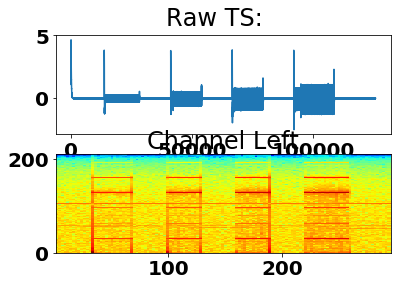

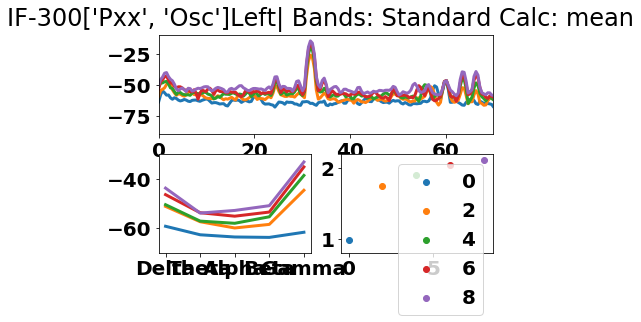

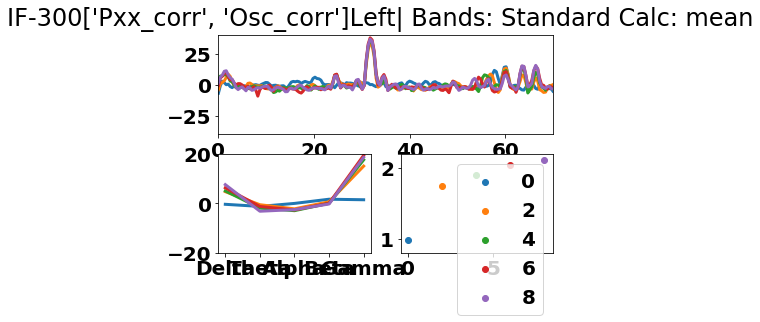

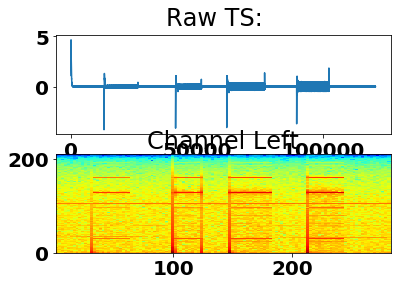

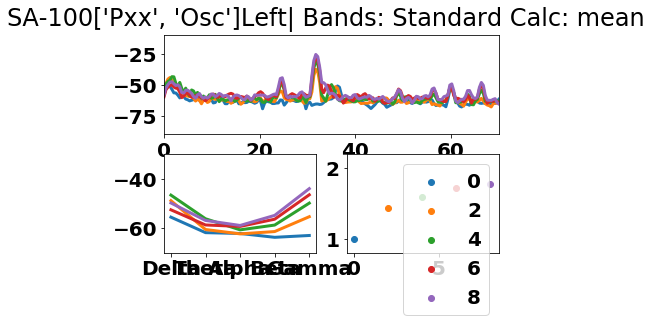

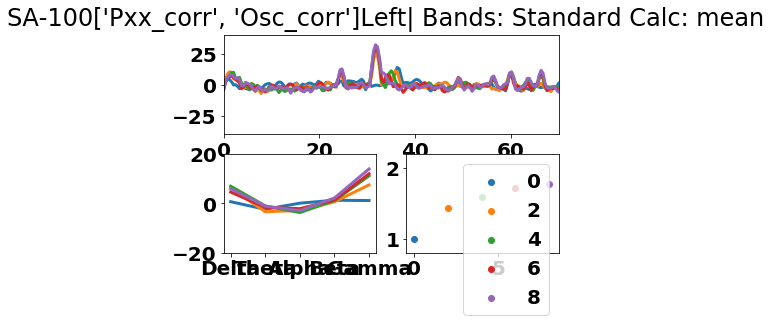

In [3]:
exp_results = nestdict()
for gel,fname in v_files.items():
    _ = spot_check(fname,tlims=(0,-1),plot_sg=True)
    
    # Go to each voltage in the sweep
    for stim_v,iv in stim_vs.items():
        exp_results[stim_v] = spot_check(fname,tlims=iv,plot_sg=False)
        
        #try some timedomain corrections
        #precorr_td = {chann:normalize(exp_results[stim_v]['TS'][:,cc]) for cc,chann in enumerate(chann_label)}
        #exp_results[stim_v]['TS_Corr'] = np.array([np.arctanh(precorr_td[chan]) for chan in chann_label])
        
        #Get ready for CORRECTION
        precorr_psd = {cc:10*(exp_results[stim_v]['F']['Pxx'][cc]) for cc in chann_label}
        
        poly_ret = dbo.poly_subtr(precorr_psd,exp_results[stim_v]['F']['F'])
        
        exp_results[stim_v]['F']['Pxx_corr'] = poly_ret[0]
        exp_results[stim_v]['F']['PolyItself'] = poly_ret[1]
        
        
        #now do oscillatory state stuff
        #Uncorrected
        state_vect,state_basis = dbo.calc_feats(exp_results[stim_v]['F']['Pxx'],exp_results[stim_v]['F']['F'],modality='lfp',dofeats=do_feats[band_approach],compute_method=do_calc)
        exp_results[stim_v]['Osc'] = {'State':state_vect,'Basis':state_basis}
        
        state_vect,state_basis = dbo.calc_feats(exp_results[stim_v]['F']['Pxx_corr'],exp_results[stim_v]['F']['F'],modality='lfp',dofeats=do_feats[band_approach],compute_method=do_calc)
        exp_results[stim_v]['Osc_corr'] = {'State':state_vect,'Basis':state_basis}
        
        #Finally, we're just going to do the Gain Compression Ratio
        exp_results[stim_v]['GCratio'],_ = dbo.calc_feats(exp_results[stim_v]['F']['Pxx'],exp_results[stim_v]['F']['F'],modality='lfp',dofeats=['GCratio'],compute_method=do_calc)


    #go to each preprocessing flow
    for plot_proc in preproc_flows:
        plt.figure()
        for v_stim in do_stimvs:
            plt.subplot(2,1,1)
            plt.plot(exp_results[v_stim]['F']['F'],10*np.log10(exp_results[v_stim]['F'][plot_proc[0]][do_side]),linewidth=3)
            plt.xlim((0,70))
            if plot_proc[0][-4:] == 'corr':
                plt.ylim((-40,40))
            else:
                pass
                plt.ylim((-90,-10))
            #plt.plot(exp_results[v_stim]['F']['F'],exp_results[v_stim]['F']['PolyItself']) #This seems to be doing something weird even in the left channel, should check
            plt.subplot(2,2,3)
            plt.plot(exp_results[v_stim]['Osc']['Basis'],exp_results[v_stim][plot_proc[1]]['State'][:,side_idx[do_side]],linewidth=3)
            
            if plot_proc[0][-4:] == 'corr':
                plt.ylim((-20,20))
            else:
                pass
                plt.ylim((-70,-30))
            
            
            plt.subplot(2,2,4)
            plt.scatter(v_stim,exp_results[v_stim]['GCratio'][side_idx[do_side]])
            plt.ylim((0.8,2.2))
            
        plt.legend(do_stimvs)
        plt.suptitle(gel + str(plot_proc) + do_side + '| Bands: ' + band_approach + ' Calc: ' + do_calc)
        